# Supplementary Table 3. DROSHA processing result
---

In [1]:
import time
today = time.strftime('%Y-%m-%d')
name = 'Seungchan Baek'
print 'Last revised by %s at %s.' % (name, today)

Last revised by Seungchan Baek at 2021-01-12.


In [2]:
home = '/casa/bsc/projects/1_DCS/2004_paper_prep/'
%cd $home

/casa/bsc/projects/1_DCS/2004_paper_prep


In [3]:
from __future__ import division
import sys; sys.path.append('/casa/bsc/notebooks/')
from basic import gen_result_dir
resultpath = gen_result_dir('results/')
print 'resultpath:', resultpath

resultpath: results/210112/


In [4]:
import pandas as pd
import numpy as np
import re
import gzip
from matplotlib import pyplot as plt
from collections import defaultdict, Counter
from scipy.stats import spearmanr, pearsonr
from util import *
%matplotlib inline

In [5]:
LIBRARIES = [ 'set1', 'set2', 'set3', 'set4', 'set5' ]

In [371]:
s1 = pd.read_csv('supplementary/TableS1__Previously_identified_DROSHA-dependence.csv', 
                 header=1, index_col=0)
s2 = pd.read_csv('supplementary/TableS2__Oligonucleotides_used_in_this_study.csv', 
                 header=1, index_col=0).fillna('')
s3 = pd.read_csv('supplementary/TableS3__In_vitro_processing_results_Microprocessor-only.csv',
                 header=1, index_col=0)
s4 = pd.read_csv('supplementary/TableS4__Cis-acting_elements_of_human_pri-miRNAs.csv', 
                 header=1, index_col=0)
inpraw = pd.read_csv('supplementary/TableSub__input_Microprocessor.csv',header=1,index_col=0)
clvraw = pd.read_csv('supplementary/TableSub__cleavage_products_Microprocessor.csv',index_col=0)

In [373]:
preposition = {}
for mir in s2.index:
    flank5, flank3 = s2.loc[mir,["5' flanking segment","3' flanking segment"]]
    if flank5 or flank3:
        preposition[mir] = (len(flank5)+1,125-len(flank3))
    else:
        preposition[mir] = (0,126)
print len(preposition), preposition['hsa-mir-142']

1881 (32, 90)


In [372]:
inpsum = pd.DataFrame()
for inp in ['set1','set3','set5']:
    inpsum[inp] = inpraw[['%s-1'%inp,'%s-2'%inp]].sum(axis=1)
inpsum['set2'] = inpraw['set2']
inpsum['set4'] = inpraw['set4'] 
inpsum = inpsum[LIBRARIES]
inpsum.head(1)

,set1,set2,set3,set4,set5
Pri-miRNA,,,,,
hsa-let-7a-1,1373,474,0,2,0


In [375]:
clvraw = clvraw.set_index(['Pri-miRNA','rstart','rend'])
clvtbl = pd.DataFrame()
for lib in LIBRARIES:
    clvtbl[lib] = clvraw[['%s-1'%lib,'%s-2'%lib]].sum(axis=1)
clvtbl = clvtbl.reset_index()
clvtbl.head(1)

,Pri-miRNA,rstart,rend,set1,set2,set3,set4,set5
0,hsa-let-7a-1,1,8,4.0,4.0,0.0,0.0,0.0


In [376]:
start, mid, end = 1, 63, 125
clv5f = clvtbl[(clvtbl['rstart']==start)&(clvtbl['rend']<mid)].set_index('Pri-miRNA')
clv3f = clvtbl[(clvtbl['rstart']>mid)&(clvtbl['rend']==end)].set_index('Pri-miRNA')
clvhn = clvtbl[(clvtbl['rstart']<mid)&(clvtbl['rend']>mid)]
clvn5 = clvhn[clvhn['rstart']==start]
clvn3 = clvhn[clvhn['rend']==end]
clvh = clvhn.drop(clvn5.index).drop(clvn3.index).set_index('Pri-miRNA')
clvn5 = clvn5.set_index('Pri-miRNA'); clvn3 = clvn3.set_index('Pri-miRNA')

In [377]:
def fill_unfound(tbl):
    found = set(tbl.index)
    unfound = [ mir for mir in s2.index if mir not in found ]
    fill = pd.DataFrame(index=unfound, columns=tbl.columns).fillna(0)
    return tbl.append(fill)

In [378]:
clvtbl = fill_unfound(clvtbl.set_index('Pri-miRNA'))
clv5f = fill_unfound(clv5f)
clv3f = fill_unfound(clv3f)
clvh = fill_unfound(clvh)
clvn5 = fill_unfound(clvn5)
clvn3 = fill_unfound(clvn3)

---

### Efficiency

In [21]:
RCUTOFF = 30
RCUTOFFH = 10
FCUTOFF = .01
WINDOW = 3
INVERTED = 11

In [22]:
def get_clv_cnts(mir, lib):
    ps, pe = preposition[mir]
    invs = ps+INVERTED
    inve = pe-INVERTED
    clv5 = clv5f.loc[[mir]].reset_index().set_index('rend')[lib]
    clv3 = clv3f.loc[[mir]].reset_index().set_index('rstart')[lib]
    prod5 = clv5.reindex(range(ps-1-WINDOW,ps+WINDOW)).sum()
    prod3 = clv3.reindex(range(pe+1-WINDOW,pe+2+WINDOW)).sum()
    inv5 = clv5.reindex(range(invs-1-WINDOW,invs+WINDOW)).sum()
    inv3 = clv3.reindex(range(inve+1-WINDOW,inve+2+WINDOW)).sum()
    #print prod5, prod3, inv5, inv3
    return int((prod5+prod3)/2)-int((inv5+inv3)/2)

In [23]:
clvcnts = pd.DataFrame()
for lib in LIBRARIES:
    mirs = [ m for m in inpsum[inpsum[lib]>=RCUTOFF].index if preposition[m][0]>0 ]
    for mir in mirs:
        clvcnts.loc[mir,lib] = get_clv_cnts(mir,lib)
clvcnts.head()

,set1,set2,set3,set4,set5
hsa-let-7a-1,16541.0,1317.0,NaN,NaN,NaN
hsa-let-7a-2,14892.0,2305.0,NaN,NaN,NaN
hsa-let-7a-3,5490.0,313.0,NaN,NaN,NaN
hsa-let-7b,12439.0,806.0,NaN,NaN,NaN
hsa-let-7c,-2904.0,-193.0,NaN,NaN,NaN


In [379]:
## norm
norm = 'hsa-mir-6838'# 'hsa-mir-6788'
norms = clv5f.loc[norm,LIBRARIES].sum()/inpsum.loc[norm,LIBRARIES]
norms

set1    0.773292
set2    0.075906
set3    0.019677
set4    0.082859
set5    0.083832
dtype: float64

In [67]:
def calculate_efficiency(mir,lib,norms):
    clv = clvcnts.loc[mir,lib]
    inp = inpsum.loc[mir,lib]
    return np.log2(max(clv,0)/inp/norms[lib]+1)

In [233]:
sufflibs = {}
for m in clvcnts.index:
    libs = [ l for l in clvcnts.loc[m].dropna().index if clv5f.loc[m,l].sum()>=RCUTOFF 
             and clv3f.loc[m,l].sum()>=RCUTOFF and clvh.loc[m,l].sum()>=RCUTOFFH ]
    if libs:
        sufflibs[m] = max(libs,key=lambda x: clvtbl.loc[m,x].sum())
    else:
        sufflibs[m] = clvcnts.loc[m].dropna().index[0]

In [236]:
effs = {}
for mir in clvcnts.index:
    lib = sufflibs[mir]
    effs[mir] = calculate_efficiency(mir,lib,norms)
print len(effs), effs['hsa-mir-144']

1816 3.9821827301972217


---

### Homogeneity

In [35]:
def get_frac_5frag(mir):
    sub = clv5f.loc[[mir]].set_index('rend')
    return (sub/sub.sum())

In [36]:
def get_frac_3frag(mir):
    sub = clv3f.loc[[mir]].set_index('rstart')
    return (sub/sub.sum())

In [37]:
def get_frac_hairpin(mir):
    sub = clvh.loc[[mir]].set_index(['rstart','rend'])
    return (sub/sub.sum())

In [38]:
def filter_frac(frac):
    return frac[frac>=FCUTOFF]

In [39]:
def drop_duplicates(sortedtbl):
    if len(sortedtbl)<=1:
        return sortedtbl
    hs = sortedtbl['hstart'].tolist()[0]
    he = sortedtbl['hend'].tolist()[0]
    sub = sortedtbl.iloc[1:]
    sub = sub[(sub['hstart']!=hs)&(sub['hend']!=he)]
    return sortedtbl.iloc[:1].append(drop_duplicates(sub))

In [40]:
frac5f = { mir:get_frac_5frag(mir) for mir in s2.index } 
frac3f = { mir:get_frac_3frag(mir) for mir in s2.index } 
frachpn = { mir:get_frac_hairpin(mir) for mir in s2.index }

In [221]:
cols = 'miRNA pstart pend hstart hend 5frag 3frag hairpin score diff5 diff3'.split()

In [238]:
def get_dcs(mir, lib):
    ps, pe = preposition[mir]
    null = pd.DataFrame({0:dict(zip(cols,[mir,ps,pe,1,125,0,0,0,0,99,99]))}).T[cols]
    cs = null
    sum5f = clv5f.loc[mir,lib].sum()
    sum3f = clv3f.loc[mir,lib].sum()
    sumh = clvh.loc[mir,lib].sum()
    if not (sum5f>=RCUTOFF and sum3f>=RCUTOFF and sumh>=RCUTOFFH):
        return null
    
    clv5, clv3, clvhpn = [ f[mir][lib] for f in [frac5f,frac3f,frachpn] ]
    clv52 = defaultdict(float); clv52.update(clv5)
    clv32 = defaultdict(float); clv32.update(clv3)
    clvhpn2 = defaultdict(float); clvhpn2.update(clvhpn)
    for c5, frac5 in filter_frac(clv5).items():
        for c3, frac3 in filter_frac(clv3).items():
            row = dict(zip(cols,[mir,ps,pe,c5+1,c3-1,frac5,frac3,clvhpn2[(c5+1,c3-1)]]))
            cs = cs.append(row, ignore_index=True)
    for (c5,c3), frach in filter_frac(clvhpn).items():
        row = dict(zip(cols,[mir,ps,pe,c5,c3,clv52[c5-1],clv32[c3+1],frach]))
        cs = cs.append(row, ignore_index=True)
    cs['score'] = (cs['5frag']+cs['hairpin']+cs['3frag'])/3
    cs['diff5'] = cs['hstart']-cs['pstart']
    cs['diff3'] = cs['pend']-cs['hend']
    cs = cs[(abs(cs['diff5'])<=WINDOW)&(abs(cs['diff3'])<=WINDOW)]
    if len(cs)>=1:
        return drop_duplicates(cs.sort_values('score').iloc[::-1])
    return null

In [240]:
mir = 'hsa-mir-551a'
get_dcs(mir, sufflibs[mir])

,miRNA,pstart,pend,hstart,hend,5frag,3frag,hairpin,score,diff5,diff3
7,hsa-mir-551a,32,91,32,91,0.962617,0.955556,0.974359,0.964177,0,0


In [242]:
print time.ctime()
clvall = pd.DataFrame(columns=cols)
for mir in sorted(effs.keys()):
    clvall = clvall.append(get_dcs(mir,sufflibs[mir]), ignore_index=True)
clvall = clvall[cols]
print time.ctime()
print '# of all sites:\t%s' % len(clvall)
print '# of miRNAs:\t%s' % len(set(clvall['miRNA']))

Tue Jan 12 08:20:31 2021
Tue Jan 12 08:42:08 2021
# of all sites:	4234
# of miRNAs:	1816


In [243]:
clvall.to_csv('resources/210111_cleavage_sites.csv')
#clvall = pd.read_csv('resources/210111_cleavage_sites.csv', index_col=0)

In [244]:
tmp = clvall.sort_values('score').drop_duplicates('miRNA',keep='last')
homs = tmp.set_index('miRNA')['score'].to_dict()

---

In [245]:
drodep = s1[s1['DROSHA dependency'].apply(lambda x:x.find('DROSHA-dependent')>=0)].index
droind = s1[s1['DROSHA dependency'].apply(lambda x:x.find('DROSHA-independent')>=0)].index
droko = s1[s1['DROSHA dependency'].apply(lambda x:x.find('DROSHA KO')>=0)].index
fclip = s1[s1['DROSHA dependency'].apply(lambda x:x.find('fCLIP')>=0)].index
print len(drodep), len(droind), len(droko), len(fclip)

304 257 157 281


In [246]:
def get_precision(cutoff, mirl, data, pcs):
    tpos = [m for m in mirl if m in pcs and data[m]>=cutoff]
    pos = [m for m in mirl if data[m]>=cutoff]
    return len(tpos)/len(pos)

In [247]:
def get_recall(cutoff, mirl, data, pcs):
    tpos = [m for m in mirl if m in pcs and data[m]>=cutoff]
    return len(tpos)/len(pcs)

In [248]:
overlap = [m for m in effs if m in homs]
testset = [ mir for mir in overlap if mir in drodep or mir in droind ]
pcs = [ mir for mir in overlap if mir in drodep ]
print len(testset), len(pcs)

553 298


In [249]:
erange = np.arange(0,3.1,.3)
eprs = [ get_precision(e,testset,effs,pcs) for e in erange ]
ercs = [ get_recall(e,testset,effs,pcs) for e in erange ]

In [250]:
hrange = np.arange(0,.71,.05)
hprs = [ get_precision(e,testset,homs,pcs) for e in hrange ]
hrcs = [ get_recall(e,testset,homs,pcs) for e in hrange ]

In [251]:
ecut = 1.5
hcut = .25
ex = get_recall(ecut,testset,effs,pcs)
ey = get_precision(ecut,testset,effs,pcs)
hx = get_recall(hcut,testset,homs,pcs)
hy = get_precision(hcut,testset,homs,pcs)
c = '#a63603'
print ex,ey,hx,hy

0.724832214765 0.964285714286 0.771812080537 0.962343096234


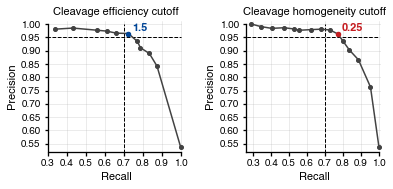

In [252]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(6,2.4))
ax1.errorbar(ercs,eprs,ms=4,marker='o',zorder=2,color='#424242')
ax2.errorbar(hrcs,hprs,ms=4,marker='o',zorder=2,color='#424242')
ax1.set_title('Cleavage efficiency cutoff',fontsize=11)
ax2.set_title('Cleavage homogeneity cutoff',fontsize=11)
for ax,xmin in zip([ax1,ax2],[ercs[-1],hrcs[-1]]):
    ax.spines['left'].set_bounds(.52,1)
    ax.spines['bottom'].set_bounds(xmin-.03,1)
    ax.set_xlim(xmin-.03,1.02)
    ax.set_ylim(.52,1.01)
    ax.set_xlabel('Recall',fontsize=11)
    ax.set_ylabel('Precision',fontsize=11)
    ax.set_xticks(np.arange(.3,1.1,.1))
    ax.set_yticks(np.arange(.55,1.05,.05))
    sq = plt.Rectangle([xmin-.03,.35],1.04-xmin,.66,fc='w'); ax.add_patch(sq)
    ax.grid(ls='-',lw=.5,clip_path=sq,which='both')
    ax.tick_params(labelsize=10)
ax1.text(ex+.02,ey+.01,ecut,fontsize=11,weight='bold',color='#004597')  
ax2.text(hx+.02,hy+.01,hcut,fontsize=11,weight='bold',color='#c61d21')
ax1.scatter([ex],[ey],s=20,color='#004597',zorder=3)
ax2.scatter([hx],[hy],s=20,color='#c61d21',zorder=3)
ax1.plot([0,1],[.95,.95],'k--',lw=1); ax1.plot([.7,.7],[0,1],'k--',lw=1)
ax2.plot([0,1],[.95,.95],'k--',lw=1); ax2.plot([.7,.7],[0,1],'k--',lw=1)
fig.subplots_adjust(wspace=.45)
#fig.savefig(resultpath + '201117_s2a__precision_recall_CH.pdf')#,dpi=300)

### Build table

In [253]:
homcut = .25
clvsig = clvall[clvall['score']>=homcut]
clvcnt = Counter(clvsig['miRNA'])

In [254]:
effcut = 1.5
overlap = [ m for m in homs if m in effs ]
dcsmirs = [ m for m in overlap if effs[m]>=effcut and homs[m]>=homcut ]
single = [ m for m in overlap if effs[m]>=effcut and clvcnt[m]==1 ]
alternative = [ m for m in overlap if effs[m]>=effcut and clvcnt[m]>=2 ]
print len(dcsmirs), len(single), len(alternative)

560 516 44


In [255]:
cols = [ 'Pri-miRNA', 'Cleavage Efficiency', 'Cleavage Homogeneity',
         "5' miRBase site", "3' miRBase site", "5' cleavage site", "3' cleavage site", 
         "5' alternative site", "3' alternative site", "Cleavage ratio of alternative site" ]
tbl = pd.DataFrame(columns=cols).set_index('Pri-miRNA')
tbl.head(1)

,Cleavage Efficiency,Cleavage Homogeneity,5' miRBase site,3' miRBase site,5' cleavage site,3' cleavage site,5' alternative site,3' alternative site,Cleavage ratio of alternative site
Pri-miRNA,,,,,,,,,


In [256]:
for pri in overlap:
    ps, pe = preposition[pri]
    tbl.loc[pri,'Cleavage Efficiency'] = effs[pri]
    tbl.loc[pri,'Cleavage Homogeneity'] = homs[pri]
    tbl.loc[pri,"5' miRBase site"] = ps
    tbl.loc[pri,"3' miRBase site"] = pe
    sub = clvall[clvall['miRNA']==pri].sort_values('score',ascending=False)
    sub = sub[sub['score']>0]
    if len(sub)>=1:
        tbl.loc[pri,"5' cleavage site"] = sub['hstart'].values[0]
        tbl.loc[pri,"3' cleavage site"] = sub['hend'].values[0]
        if len(sub)>=2:
            tbl.loc[pri,"5' alternative site"] = sub['hstart'].values[1]
            tbl.loc[pri,"3' alternative site"] = sub['hend'].values[1]
            tbl.loc[pri,"Cleavage ratio of alternative site"] = sub['score'].values[1]

In [257]:
for mir in overlap:
    ps, pe = preposition[mir]
    if ps<1 or pe>125:
        continue
    unc5 = clvn5.loc[[mir]].reset_index().set_index(['rend'])
    unc5 = unc5.reindex(range(pe-WINDOW,pe+WINDOW+1)).sum()
    unc3 = clvn3.loc[[mir]].reset_index().set_index(['rstart'])
    unc3 = unc3.reindex(range(ps-WINDOW,ps+WINDOW+1)).sum()
    hpn = clvh.loc[[mir]]
    prohpn = hpn[hpn.apply(lambda x: (x['rstart'] in range(ps-WINDOW,ps+WINDOW+1)) and 
                                  (x['rend'] in range(pe-WINDOW,pe+WINDOW+1)),axis=1)].sum()
    invhpn = hpn[hpn.apply(lambda x: (x['rstart'] in range(ps+INVERTED-WINDOW,
                                                           ps+INVERTED+WINDOW+1)) and 
                                     (x['rend'] in range(pe-INVERTED-WINDOW,
                                                         pe-INVERTED+WINDOW+1)),axis=1)].sum()
    lib = sufflibs[mir] #select_lib(mir)
    if lib in LIBRARIES and prohpn[lib].sum()>=RCUTOFFH:
        tbl.loc[mir,'5p nick processing'] = (unc3[lib]+1)/(prohpn[lib]+1)
        tbl.loc[mir,'3p nick processing'] = (unc5[lib]+1)/(prohpn[lib]+1)
        tbl.loc[mir,'Inverted processing'] = (invhpn[lib]+1)/(prohpn[lib]+1)

In [258]:
tbl.to_csv('resources/210111_s3__DROSHA_processing_result.csv')

In [259]:
out = open('supplementary/210111_s3__DROSHA_processing_result.csv', 'wt')
description = 'Supplementary Table 3. DROSHA processing result\n\n\n\n\n'
out.write(description)
for l in open('resources/210111_s3__DROSHA_processing_result.csv', 'rt'):
    out.write(l)
out.close()

In [383]:
def get_dcs_sub(mir, lib):
    ps, pe = preposition[mir]
    null = pd.DataFrame({0:dict(zip(cols,[mir,ps,pe,1,125,0,0,0,0,99,99]))}).T[cols]
    cs = null
    sum5f = clv5f.loc[mir,lib].sum()
    sum3f = clv3f.loc[mir,lib].sum()
    sumh = clvh.loc[mir,lib].sum()
    if not (sum5f>=RCUTOFF and sum3f>=RCUTOFF and sumh>=RCUTOFFH):
        return null
    
    clv5, clv3, clvhpn = [ f[mir][lib] for f in [frac5f,frac3f,frachpn] ]
    clv52 = defaultdict(float); clv52.update(clv5)
    clv32 = defaultdict(float); clv32.update(clv3)
    clvhpn2 = defaultdict(float); clvhpn2.update(clvhpn)
    for c5, frac5 in filter_frac(clv5).items():
        for c3, frac3 in filter_frac(clv3).items():
            row = dict(zip(cols,[mir,ps,pe,c5+1,c3-1,frac5,frac3,clvhpn2[(c5+1,c3-1)]]))
            cs = cs.append(row, ignore_index=True)
    for (c5,c3), frach in filter_frac(clvhpn).items():
        row = dict(zip(cols,[mir,ps,pe,c5,c3,clv52[c5-1],clv32[c3+1],frach]))
        cs = cs.append(row, ignore_index=True)
    cs['score'] = (cs['5frag']+cs['hairpin']+cs['3frag'])/3
    cs['diff5'] = cs['hstart']-cs['pstart']
    cs['diff3'] = cs['pend']-cs['hend']
    #cs = cs[(abs(cs['diff5'])<=WINDOW)&(abs(cs['diff3'])<=WINDOW)]
    return drop_duplicates(cs.sort_values('score').iloc[::-1])

In [372]:
clvcnts['hsa-mir-214']

(1039, 3642)

In [384]:
mir = 'hsa-mir-214'
get_dcs_sub(mir,'set2')

,miRNA,pstart,pend,hstart,hend,5frag,3frag,hairpin,score,diff5,diff3
184,hsa-mir-214,30,92,44,78,0.480282,0.546366,0.880399,0.635682,14,14
114,hsa-mir-214,30,92,26,79,0.101408,0.0701754,0,0.0571946,-4,13
52,hsa-mir-214,30,92,13,105,0.0732394,0.0401003,0,0.0377799,-17,-13
139,hsa-mir-214,30,92,28,108,0.0704225,0.037594,0.000664452,0.036227,-2,-16
67,hsa-mir-214,30,92,14,106,0.0633803,0.037594,0,0.0336581,-16,-14
92,hsa-mir-214,30,92,23,96,0.028169,0.037594,0,0.021921,-7,-4
161,hsa-mir-214,30,92,43,94,0.0239437,0.0350877,0,0.0196771,13,-2
107,hsa-mir-214,30,92,24,98,0.0211268,0.0250627,0.0013289,0.0158394,-6,-6
40,hsa-mir-214,30,92,12,107,0.0183099,0.0150376,0,0.0111158,-18,-15
5,hsa-mir-214,30,92,9,89,0.0169014,0.0150376,0,0.0106463,-21,3


In [386]:
synexcel = pd.ExcelFile('supplementary/synthesis_log.xlsx')
syn1mirs = synexcel.parse('1st')[0].tolist()
print len(syn1mirs)

1645


In [438]:
def get_clv_cnts_sub(mir, lib, window):
    ps, pe = preposition[mir]
    if ps<1 or pe>125:
        return -1,-1
    invs = ps+INVERTED
    inve = pe-INVERTED
    clv5 = clv5f.loc[[mir]].reset_index().set_index('rend')[lib]
    clv3 = clv3f.loc[[mir]].reset_index().set_index('rstart')[lib]
    prod5 = clv5.reindex(range(ps-1-window,ps+window)).sum()
    prod3 = clv3.reindex(range(pe+1-window,pe+2+window)).sum()
    inv5 = clv5.reindex(range(invs-1-window,invs+window)).sum()
    inv3 = clv3.reindex(range(inve+1-window,inve+2+window)).sum()
    #print prod5, prod3, inv5, inv3
    return int((prod5+prod3)/2), int((inv5+inv3)/2)

In [297]:
def calculate_efficiency(mir, lib):
    prod, inv = clvcnts[mir]
    if prod<0: 
        return -999
    inp = inpsum[lib][mir]
    return max(prod-inv,0)/inp

In [568]:
def calculate_efficiency_sub(mir, lib):
    prod, inv = get_clv_cnts(mir, lib)
    if prod<0: 
        return -999
    inp = inpsum[lib][mir]
    return max(prod-inv,0)/inp

In [408]:
def get_clv_all(mir, lib):
    clv5 = clv5f.loc[mir, lib]
    clv3 = clv3f.loc[mir, lib]
    return int(round((clv5.sum()+clv3.sum())/2, 0))

In [449]:
def get_productivity(mir, lib):
    prod, inv = get_clv_cnts_sub(mir, lib, 5)
    clv = (prod+inv)#get_clv_all(mir, lib)
    if prod<0: return -999
    if clv==0: return 0
    inp = inpsum[lib][mir]
    return (prod/inp)*(prod/clv)

In [837]:
norm = 'hsa-mir-6838'
norms = clv5f.loc[norm,LIBRARIES].sum()/inpsum.loc[norm,LIBRARIES]
norms

set1    0.773292
set2    0.075906
set3    0.019677
set4    0.082859
set5    0.083832
dtype: float64

In [838]:
effreps = {}
for m in syn1mirs:
    if (inpsum.loc[m,['set1','set2']]>=100).all() and preposition[m][0]:
        eff1 = np.log2(calculate_efficiency_sub(m,'set1')/norms['set1']+1)
        eff2 = np.log2(calculate_efficiency_sub(m,'set2')/norms['set2']+1)
        #eff1 = np.log2(get_productivity(m,'set1')/norms['set1']+1)
        #eff2 = np.log2(get_productivity(m,'set2')/norms['set2']+1)
        effreps[m] = (eff1,eff2)
print len(effreps)

1500


(-0.2, 6)

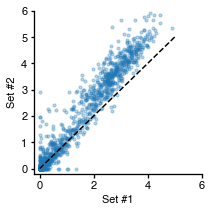

In [842]:
xs, ys = zip(*effreps.values())
fig,ax = plt.subplots(1, 1, figsize=(3,3))
ax.scatter(xs,ys,s=10,alpha=.3)
ax.set_xlabel('Set #1')
ax.set_ylabel('Set #2')
ax.plot([0,5],[0,5],'k--')
ax.set_xlim(-.2,6)
ax.set_ylim(-.2,6)
#ax.set_xticks(range(0,11,2))

In [460]:
homreps = {}
for m in syn1mirs:
    sum5f = clv5f.loc[m,['set1','set2']].sum().min()
    sum3f = clv3f.loc[m,['set1','set2']].sum().min()
    sumh = clvh.loc[m,['set1','set2']].sum().min()
    if (sum5f>=RCUTOFF and sum3f>=RCUTOFF and sumh>=RCUTOFFH):
        hom1 = get_dcs(m,'set1')['score'].max()
        hom2 = get_dcs(m,'set2')['score'].max()
        homreps[m] = (hom1,hom2)
print len(homreps)

1419


Text(0,0.5,u'Set #2')

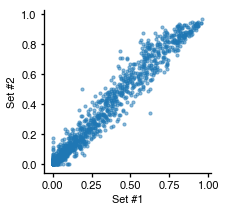

In [467]:
xs, ys = zip(*homreps.values())
fig,ax = plt.subplots(1, 1, figsize=(3,3))
ax.scatter(xs,ys,s=10,alpha=.5)
ax.set_xlabel('Set #1')
ax.set_ylabel('Set #2')
#ax.plot([0,8],[0,8],'k--')
#ax.set_xlim(-.5,6)
#ax.set_ylim(-.5,6)
#ax.set_xticks(range(0,11,2))